# Assignment 6 - Recognizing objects in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get started using the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors
 * automatic differentiation
 * layered learners
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
Mon Feb  5 08:03:15 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.12                 Driver Version: 390.12                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that I'm running a process (pid=10843) that currently takes up close to 3 GB of GPU memory.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

In the following we are going to use **[pytorch](http://pytorch.org)**, which received some praise recently for being faster than [tensorflow](http://tensorflow.org) and for also having a nice high-level API as NN modules that are similar to [Keras](https://keras.io/).

The default `conda` environment has pytorch 1.0 installed. This means, you should be able to use it without any changes to your environment.

### Use our downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.6G):
```
mkdir -p ~/.torch/models
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/models/models/* ~/.torch/models
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice blog-post by [Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

(50000, 8, 8)

(50000, 1, 4)

**Here is an example of the training data:**

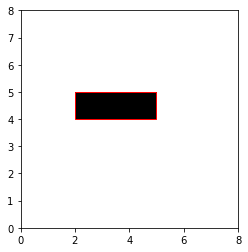

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1
np.random.seed(42)
bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
display(imgs.shape, bboxes.shape)

display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [2]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
display(X.shape, np.mean(X), np.std(X))
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
display(y.shape, np.mean(y), np.std(y))

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

(50000, 64)

-5.2533533079213156e-17

0.9999999999999998

(50000, 4)

0.280643125

0.17525066552008975

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(X.shape[-1],200)
                      ,nn.ReLU()
                      ,nn.Dropout(0.2)
                      ,nn.Linear(200,4)).to(device)

In [4]:
optimizer = torch.optim.Adagrad(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

I:\Installed\Anaconda\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [5]:
inputs = Variable(torch.Tensor(train_X)).to(device)
labels = Variable(torch.Tensor(train_y)).to(device)

In [6]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(500):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

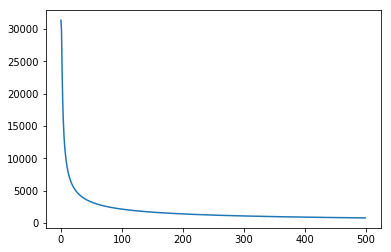

In [7]:
plt.plot(loss_record)

In [8]:
# Predict bounding boxes on the test images.
model.eval()
pred_y = model(Variable(torch.Tensor(test_X)).to(device))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.cpu().numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [9]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.820464602041463

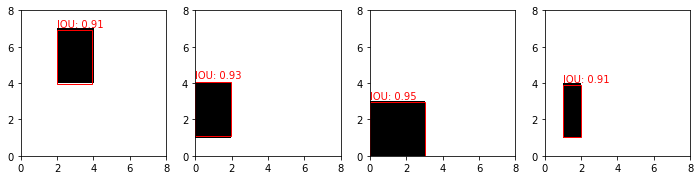

In [10]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you reach an IOU of above 0.6.
You can make the changes that move computation to the GPU directly in the cells above.

# Task 2: Use a pretrained model

As mentioned in class deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup.Copy the relevant code into this notebook, as mentioned in the submission instructions.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Display the image and class label in the notebook for submission.

### Hints for step 3

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = torchvision.models.resnet18(pretrained=True)
```
to load VGG19 instead.

Next, print out the new model_conv and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but works similarily. Identify the module that contains the last classification step of the VGG model, which identifies one out of 1000 classes. Change that one into identifying 2 classes only (i.e. the ants and bees that you should start with).

To change the structure of Sequential component called ```module_name``` and to modify its last layer into a DifferentLayer type, you can use this syntax.

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old model_conv.module_name with the differently structured version.

### Task 2-1,2:
 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup.Copy the relevant code into this notebook, as mentioned in the submission instructions.

In [11]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

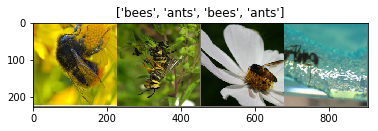

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6459 Acc: 0.6721
val Loss: 0.2081 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4191 Acc: 0.7869
val Loss: 0.1635 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4014 Acc: 0.7910
val Loss: 0.1994 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4420 Acc: 0.8156
val Loss: 0.1794 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.6843 Acc: 0.7541
val Loss: 0.4099 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.5183 Acc: 0.7951
val Loss: 0.2167 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5412 Acc: 0.7746
val Loss: 0.3414 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3723 Acc: 0.8361
val Loss: 0.1943 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3253 Acc: 0.8689
val Loss: 0.2234 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4530 Acc: 0.7787
val Loss: 0.2162 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3322 Acc: 0.8443
val Loss: 0.2253 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3632 Acc: 0.8402
val Loss: 0.2290 Acc: 0.9346

Ep

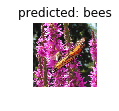

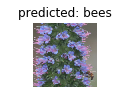

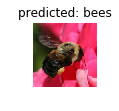

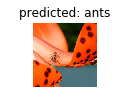

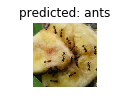

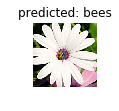

In [18]:
visualize_model(model_conv)

### Task 2-3:
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.
 
#### VGG19::

In [20]:
model_vgg19 = torchvision.models.vgg19(pretrained=True)
print(model_vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [21]:
for param in model_vgg19.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_vgg19.classifier[6].in_features
model_vgg19.classifier = nn.Sequential(*list(model_vgg19.classifier.children())[:-1] +
                     [nn.Linear(num_ftrs, 2)])

model_vgg19 = model_vgg19.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_vgg19.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [22]:
model_vgg19 = train_model(model_vgg19, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3424 Acc: 0.8770
val Loss: 0.0841 Acc: 0.9739

Epoch 1/24
----------
train Loss: 0.2015 Acc: 0.9344
val Loss: 0.1035 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.1641 Acc: 0.9467
val Loss: 0.1091 Acc: 0.9804

Epoch 3/24
----------
train Loss: 0.1350 Acc: 0.9508
val Loss: 0.0936 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.0735 Acc: 0.9631
val Loss: 0.1082 Acc: 0.9739

Epoch 5/24
----------
train Loss: 0.1519 Acc: 0.9508
val Loss: 0.1036 Acc: 0.9673

Epoch 6/24
----------
train Loss: 0.1750 Acc: 0.9426
val Loss: 0.1358 Acc: 0.9673

Epoch 7/24
----------
train Loss: 0.1457 Acc: 0.9672
val Loss: 0.1015 Acc: 0.9804

Epoch 8/24
----------
train Loss: 0.1334 Acc: 0.9549
val Loss: 0.0887 Acc: 0.9739

Epoch 9/24
----------
train Loss: 0.1628 Acc: 0.9426
val Loss: 0.0847 Acc: 0.9739

Epoch 10/24
----------
train Loss: 0.1431 Acc: 0.9426
val Loss: 0.0828 Acc: 0.9739

Epoch 11/24
----------
train Loss: 0.1239 Acc: 0.9508
val Loss: 0.0835 Acc: 0.9739

Ep

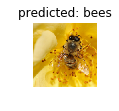

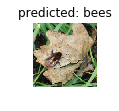

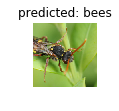

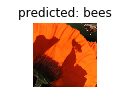

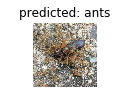

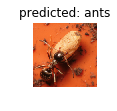

In [23]:
visualize_model(model_vgg19)

#### Densenet161::

In [24]:
model_dense = torchvision.models.densenet161(pretrained=True)
print(model_dense)

I:\Installed\Anaconda\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

)


In [25]:
for param in model_dense.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_dense.classifier.in_features
model_dense.classifier = nn.Linear(num_ftrs, 2)

model_dense = model_dense.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_dense.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_dense = train_model(model_dense, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7168 Acc: 0.6066
val Loss: 0.2251 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.3621 Acc: 0.8320
val Loss: 0.1458 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.5602 Acc: 0.7992
val Loss: 0.1007 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.3435 Acc: 0.8361
val Loss: 0.1264 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.3555 Acc: 0.8279
val Loss: 0.1111 Acc: 0.9673

Epoch 5/24
----------
train Loss: 0.2842 Acc: 0.8648
val Loss: 0.1205 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4416 Acc: 0.8033
val Loss: 0.0925 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3535 Acc: 0.8402
val Loss: 0.0966 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.2879 Acc: 0.8730
val Loss: 0.0972 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2448 Acc: 0.8975
val Loss: 0.1059 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3053 Acc: 0.8566
val Loss: 0.0811 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.2914 Acc: 0.8852
val Loss: 0.0877 Acc: 0.9608

Ep

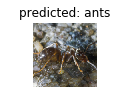

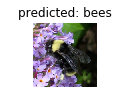

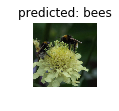

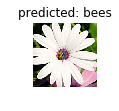

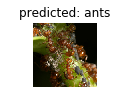

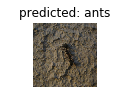

In [27]:
visualize_model(model_dense)

### Task 2-4:
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Display the image and class label in the notebook for submission.
 
#### Prediction using Densenet161 pretrained model::

In [28]:
import io
import requests
from PIL import Image

LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

In [29]:
model_dense_pred = torchvision.models.densenet161(pretrained=True)
model_dense_pred.eval()
loader =transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

I:\Installed\Anaconda\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [30]:
def classify(img,model,transform):
    img_tensor = transform(img)
    img_tensor.unsqueeze_(0)
    img_variable = Variable(img_tensor)
    fc_out = model(img_variable)
    labels = {int(key):value for (key, value)
              in requests.get(LABELS_URL).json().items()}
    item = fc_out.data.numpy().argmax()
    print(item,":",labels[item])

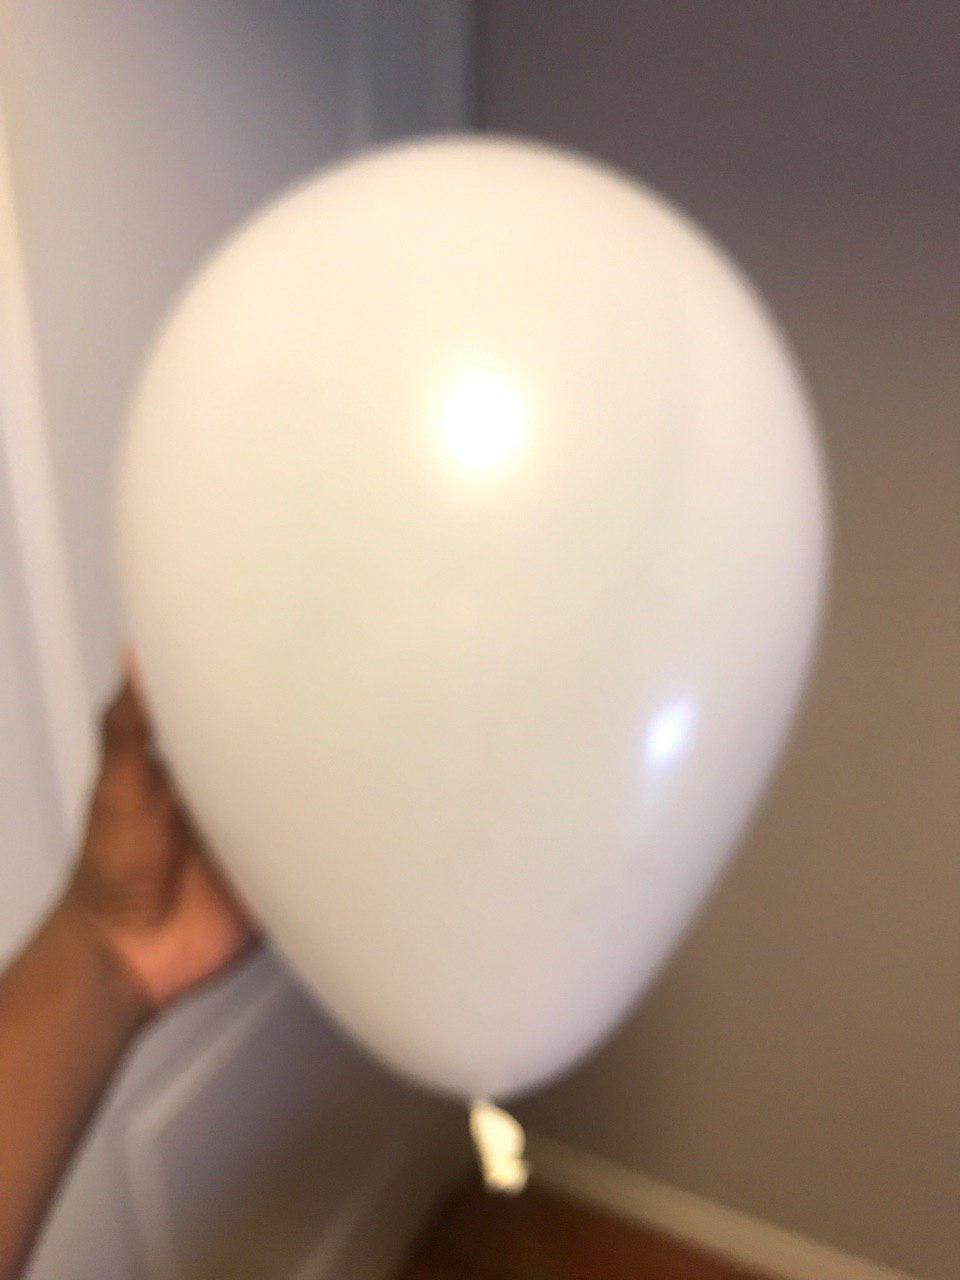

In [31]:
unclear_balloon = Image.open("images/balloon_unc.jpg")
unclear_balloon

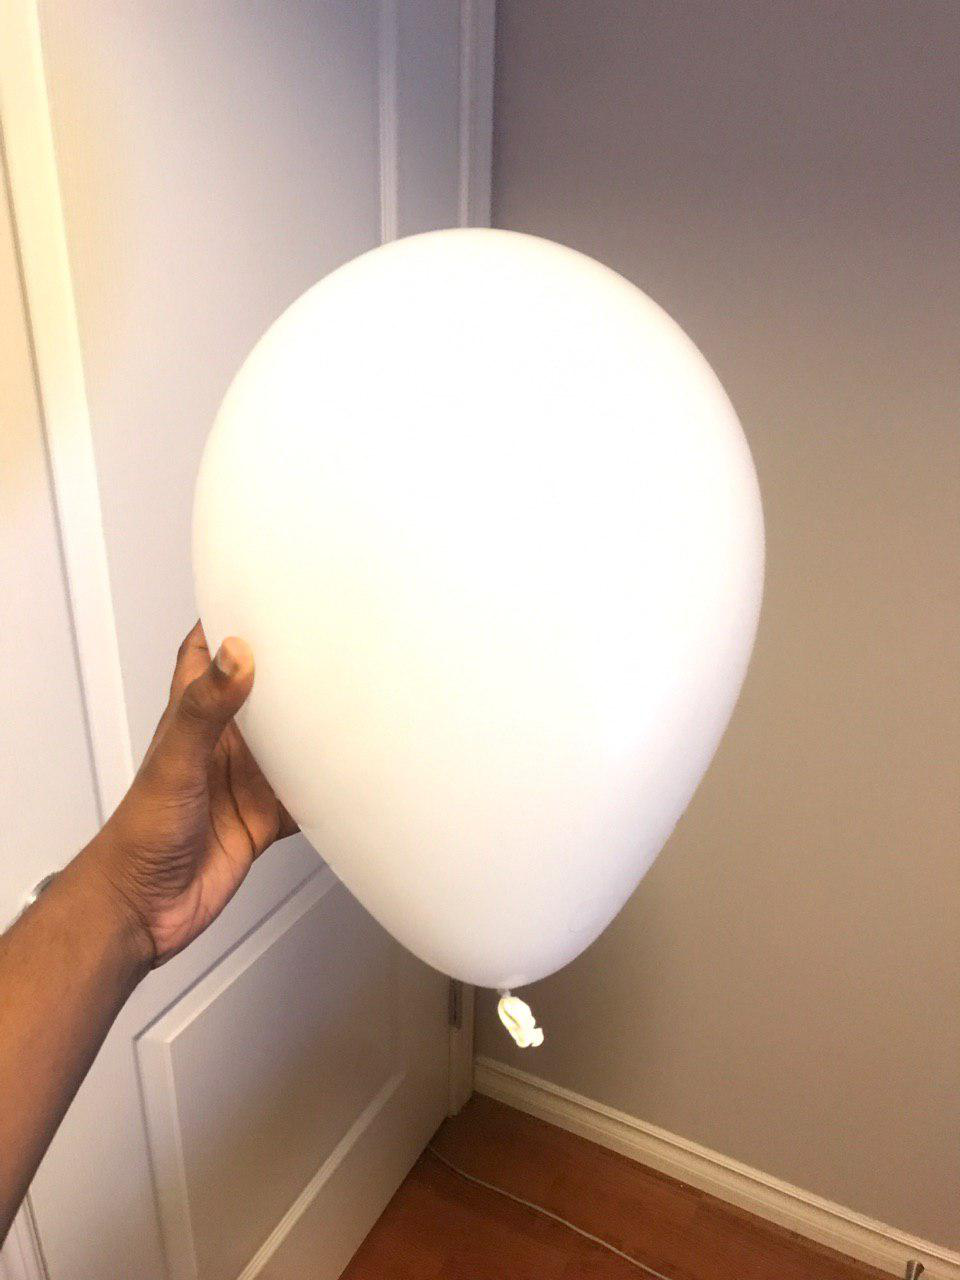

In [32]:
clear_balloon = Image.open("images/balloon_cl.jpg")
clear_balloon

In [33]:
classify(unclear_balloon,model_dense_pred,loader)
classify(clear_balloon,model_dense_pred,loader)

417 : balloon
417 : balloon


## Submission

For task 1 add your changes to the cells in this notebook.

For task 2 append the required fields of the the transfer learning tutorial to this notebook and make the required modifications. Ensure that you have clear section headings that show where you undertake which parts of the question.

Save this notebook containing all images and upload your submission as one [A6.ipynb](A6.ipynb) file.